In [3]:
import sys
import os
import shutil
import traceback

sys.path.append(os.path.abspath(os.getcwd()))
import Utils

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


In [4]:

# Example
directory = Utils.Directory(case_name="test_case_5")
case_number = 0

# RVE Analysis
from RVE import RVE
panel = RVE(
    directory=directory,
    case_number=case_number,
)
panel.analysis()

	UPDATE: starting RVE analysis test_case_5 - 0
	UPDATE: analysis for test_case_5 - 0 completed in 28.00s


In [5]:
# Fairing Analysis
from Fairing import FairingAnalysis
fairing = FairingAnalysis(
    RVE_identifier=panel.case_number, 
    directory=directory, 
    case_number=case_number,
)
fairing.analysis()



	UPDATE: starting FairingAnalysis analysis test_case_5 - 0


	UPDATE: analysis for test_case_5 - 0 failed to complete
Traceback (most recent call last):
  File "c:\Users\nm16829\Documents\PostDoc_Local_Drive\Spatial_Variation_v2\Utils.py", line 104, in load_object
    return pickle.load(f, encoding='latin1')
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'FairingData' on <module '__main__'>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\nm16829\Documents\PostDoc_Local_Drive\Spatial_Variation_v2\Utils.py", line 17, in wrapper
    result = func(*args, **kwargs)
  File "c:\Users\nm16829\Documents\PostDoc_Local_Drive\Spatial_Variation_v2\Fairing.py", line 1272, in analysis
    self.post_process_results()
    ~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\Users\nm16829\Documents\PostDoc_Local_Drive\Spatial_Variation_v2\Fairing.py", line 1226, in post_process_results
    fairing_data = Utils.load_object(os.path.join(self.directory.case_folder, "data", 

In [6]:
# Trace principal strain directions 
import Utils
from Fairing import FairingData  
from Tailoring import Lattice
lattice_data = Lattice(directory, case_number)
lattice_data.analysis()

Lattice field for folding angles (deg): ['0.0', '5.0', '10.0', '15.0']
	UPDATE: trace_streamlines for test_case_5 - 0 completed in 4.09s
	UPDATE: analysis for test_case_5 - 0 completed in 9.74s


	UPDATE: create_fairing_2D for test_case_5 - 0 completed in 26.90s


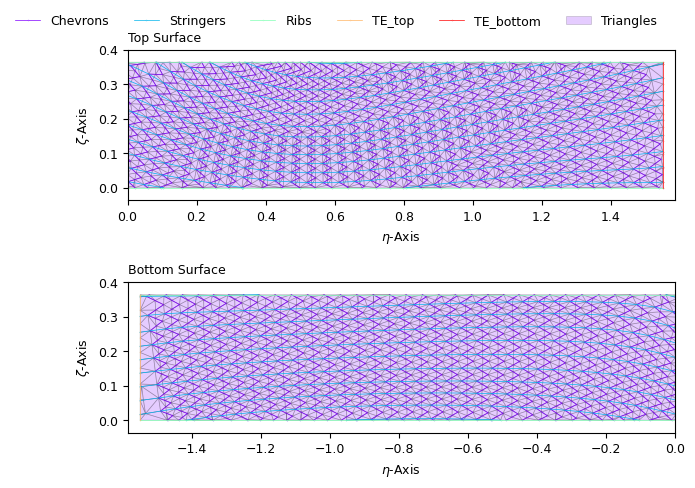

In [7]:
# Generate field-aligned lattice
from Tailoring import Tailored    
tailored = Tailored(directory, case_number, lattice_data=lattice_data)
tailored.create_fairing_2D(bool_plot=True)

# 2D Mesh Plot
increment_key = "15"
tailored.mesh2D[increment_key].plot_2D(
    {"group_sets": [], "triangle_sets": []},
    False,
    os.path.join(directory.case_folder, "fig", f"{case_number}_initial_2D_{increment_key}.svg"),
    True
)


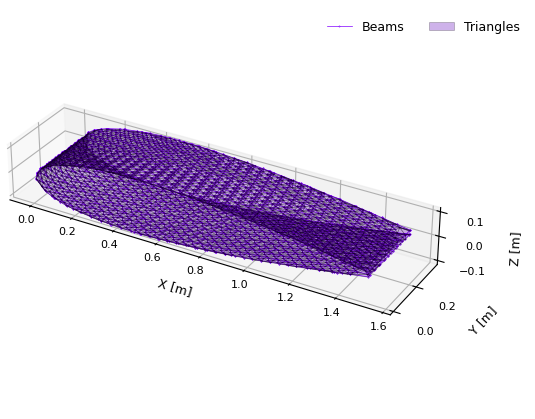

In [8]:
# Mapping lattice to 3D wing
tailored.mapping_2D_to_3D(bool_plot=True)
tailored.validate_midplane_mesh()

# 3D Mesh Plot
increment_key = "15"
tailored.mesh3D[increment_key].plot_3D(
    {"beam_sets": [], "triangle_sets": []},
    False,
    os.path.join(directory.case_folder, "fig", f"{case_number}_tailored_3D_{increment_key}.svg"),
    True
)

In [9]:
increment_key = "15"
print(tailored.mesh3D[increment_key].__dict__.keys())
print(tailored.mesh3D[increment_key].beam_sets.keys())
print(tailored.mesh3D[increment_key].beam_sets["TE_top"])
print(tailored.mesh3D[increment_key].beam_sets["TE_bottom"])




dict_keys(['dim', 'nodes', 'beams', 'triangles', 'nsets', 'beam_sets', 'triangle_sets', 'groups', '_intersection_nodes_indices'])
dict_keys(['Chevrons', 'Stringers', 'Ribs', 'TE_top', 'TE_bottom'])
[3796 3797 3798 3799 3800 3801 3802 3803 3804 3805 3806 3807 3808 3809
 3810 3811 3812 3813 3814]
[3815 3816 3817 3818 3819 3820 3821 3822 3823 3824 3825 3826 3827 3828
 3829 3830 3831 3832 3833]


In [10]:
print(tailored.mesh3D["15"].__dict__.keys())
print(fairing.__dict__.keys())

dict_keys(['dim', 'nodes', 'beams', 'triangles', 'nsets', 'beam_sets', 'triangle_sets', 'groups', '_intersection_nodes_indices'])
dict_keys(['directory', 'case_number', 'var', 'RVE_variables', 'mesh_data', 'job_file', 'log_file', 'run_folder'])
